<h1>
Pruned Variables, Pruned Values, Aggregated Target (No Separate Morbidities)
</h1>

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import KBinsDiscretizer
from IPython.display import display
from pytetrad.tools.TetradSearch import TetradSearch
from graphviz import Source
import pydot
import matplotlib.pyplot as plt

BASE_DIR = Path().resolve()

In [ ]:
df = pd.read_csv(BASE_DIR / 'data' / "natality_7yr_test_data_for_dag_1.csv")
df['date'] = pd.to_datetime(df['date'])

df

,date,morbidity_reported,dmar,precare_binary,mracehisp,meduc,fracehisp,feduc,rf_pdiab,rf_gdiab,...,rf_cesarn,combgest,dbwt,mager,fagecomb,congenital_anomalies,smoking,hospital_birth_binary,std_pos,twins_plus
0,2020-01-20,0,1,1,1,3,1,3,0,0,...,0.0,40.0,3570.0,25,30.0,0,0,1,0,0
1,2020-02-03,0,1,1,1,6,6,8,0,0,...,0.0,39.0,3560.0,28,27.0,0,0,1,0,0
2,2020-02-03,0,1,1,1,8,1,7,0,0,...,0.0,39.0,3130.0,36,35.0,0,0,1,0,0
3,2020-02-03,0,1,1,1,6,1,4,0,0,...,0.0,40.0,2760.0,32,34.0,0,0,1,0,0
4,2020-02-03,0,1,1,1,8,6,8,0,0,...,2.0,38.0,2948.0,39,44.0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169336,2019-01-14,0,2,1,1,3,1,3,0,0,...,0.0,39.0,3345.0,19,22.0,0,0,1,0,0
169337,2019-01-14,0,2,1,1,3,2,3,0,0,...,0.0,39.0,4586.0,20,24.0,0,1,1,0,0
169338,2019-01-14,0,2,1,2,6,2,3,0,0,...,0.0,39.0,3240.0,28,29.0,0,0,1,0,0
169339,2019-01-14,0,2,1,1,3,1,3,0,0,...,0.0,35.0,1985.0,27,37.0,0,0,1,0,1


In [3]:
sampled = (
    df.groupby(df['date'].dt.year, group_keys=False)
      .apply(lambda g: g.sample(n=5000, random_state=42))
      .reset_index(drop=True)
)

In [4]:
continuous_cols_to_transform = [
    'bmi', 'time_sin', 'time_cos'
]

discrete_cols_to_transform  = [
    "precare", 'previs', 'pwgt_r', 'wtgain', 'rf_cesarn', 'combgest', 'dbwt',
    'mager', 'fagecomb'
]

Since most of our variables are one-hot / binary, we're going to convert them to bins so we can use one algorithm to generate & explore the DAG.

In [5]:
# We're dropping these because we have discrete versions of them, which might be more informative for the DAG.
binary_cols_to_drop = ["precare_binary"]
df_discrete = sampled.drop(columns=binary_cols_to_drop)

discretizer = KBinsDiscretizer(
    n_bins=4,
    encode='ordinal',
    strategy='uniform',
    quantile_method='averaged_inverted_cdf'
)

cols_to_transform = continuous_cols_to_transform + discrete_cols_to_transform

df_discrete[cols_to_transform] = discretizer.fit_transform(df_discrete[cols_to_transform])
df_discrete[cols_to_transform] = df_discrete[cols_to_transform].astype('int32')

constant_cols = [c for c in df_discrete.columns if c != 'date' and df_discrete[c].nunique() <= 1]
if constant_cols:
    print("Dropping constant columns:", constant_cols)
    df_discrete = df_discrete.drop(columns=constant_cols)

X = df_discrete.drop(columns=["date"]).astype(int)
names = df_discrete.drop(columns=["date"]).columns.tolist()

In [6]:
X.describe()

,morbidity_reported,dmar,mracehisp,meduc,fracehisp,feduc,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,...,rf_cesarn,combgest,dbwt,mager,fagecomb,congenital_anomalies,smoking,hospital_birth_binary,std_pos,twins_plus
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,...,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,0.015343,1.329171,2.179257,4.336286,2.167400,4.044200,0.012943,0.081514,0.042343,0.122229,...,0.046486,2.255857,1.668629,1.157057,0.567400,0.002286,0.064743,0.974714,0.023029,0.034000
std,0.122914,0.469919,1.984276,1.668607,1.976245,1.615525,0.113030,0.273627,0.201373,0.327554,...,0.224971,0.499487,0.531602,0.694676,0.547287,0.047755,0.246075,0.156994,0.149996,0.181232
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,3.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,2.000000,2.000000,6.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,2.000000,7.000000,8.000000,9.000000,8.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
describe_df = X.describe()

describe_df.to_csv('describe_df.csv')

<h2>PC Stable</h2>

In [8]:
searcher = TetradSearch(X)
searcher.add_to_tier(0, 'mracehisp')
searcher.add_to_tier(0, 'fracehisp')
searcher.add_to_tier(0, 'time_cos')
searcher.add_to_tier(0, 'time_sin')
searcher.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher.set_forbidden(v, 'time_sin')

Note: in this first DAG-generatio notebook, I have kept some of the commented out code so that folks can see other algorithms we tried to use (like fges and grasp). These blocks are removed from subsequent DAG-generating notebooks.

In [9]:
# Scorers
# stronger smoothing + sparsity
# sample_prior: BDeu Equivalent Sample Size, ESS; data likelihood becomes less spiky,
# so the score doesn’t wildly prefer some parent sets due to accidental sparse counts.
# structure_prior: prior on the number of edges; constrains the number of edges

# searcher.use_bdeu(sample_prior=12, structure_prior=8)

# Tests
#searcher.use_chi_square()
searcher.use_g_square(alpha=0.05) # alpha=0.05

In [10]:
# searcher.run_fges(parallelized=True, faithfulness_assumed=True, symmetric_first_step=True, max_degree=5)
# searcher.run_grasp(covered_depth=2, use_data_order=True, ordered_alg=True)

searcher.run_pc(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6}, 3={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 4={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 5={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3}, 13={0=0, 1=1, 2=2, 3=3}, 14={0=0, 1=1}, 15={0=0, 1=1}, 16={0=0, 1=1}, 17={0=0, 1=1}, 18={0=0, 1=1}, 19={0=0, 1=1}, 20={0=0, 1=1}, 21={0=0, 1=1}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3, 4=4, 5=5}, 24={0=0, 1=1, 2=2, 3=3}, 25={0=0, 1=1}, 26={0=0, 1=1}, 27={0=0, 1=1}, 28={0=0, 1=1}, 29={0=0, 1=1}, 30={0=0, 1=1}, 31={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8, 9=9, 10=10, 11=11}, 32={0=0, 1=1, 2=2, 3=3}, 33={0=0, 1=1, 2=2, 3=3}, 34={0=0, 1=1, 2=2, 3=3}, 35={0=0, 1=1}, 36={0=0, 1=1, 2=2, 3=3}, 37={0=0, 1=1, 2=2, 3=3}, 38={0=0, 1=1, 2=2, 3=3}, 39={0=0, 1=1, 2=2, 3=3}, 40={0=0, 1=1, 2=2, 3=3}, 41={0=0, 1=1, 2=2, 3=3}, 42={0=0, 1=1, 2=2, 3=

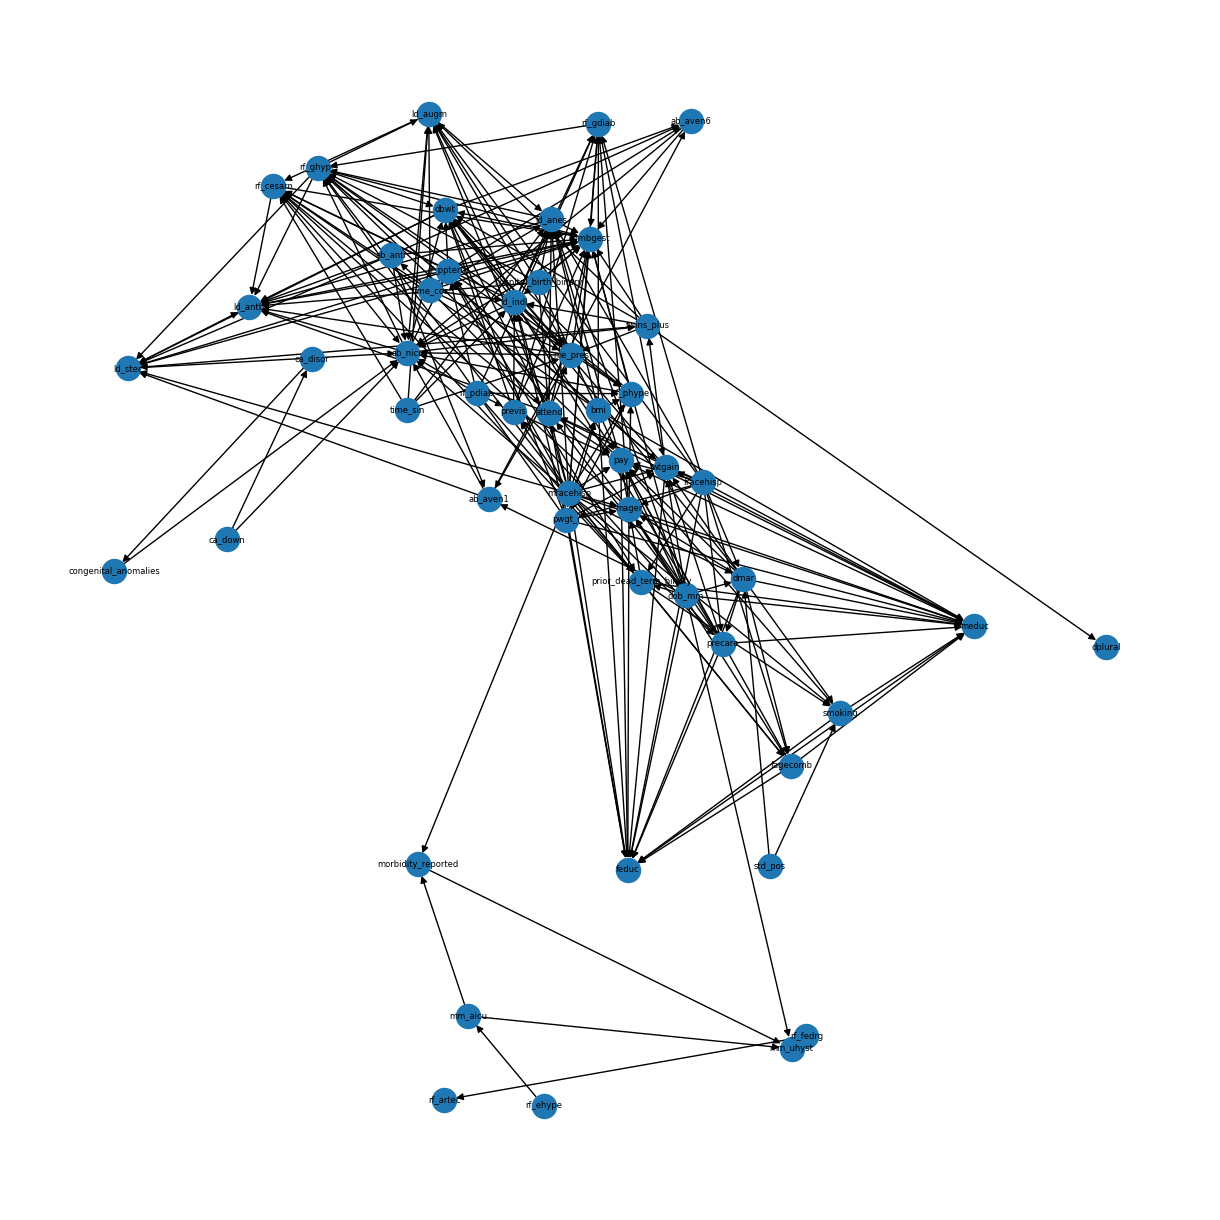

In [11]:
pydot_graph = pydot.graph_from_dot_data(searcher.get_dot())[0]
G = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.6)
nx.draw(G, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

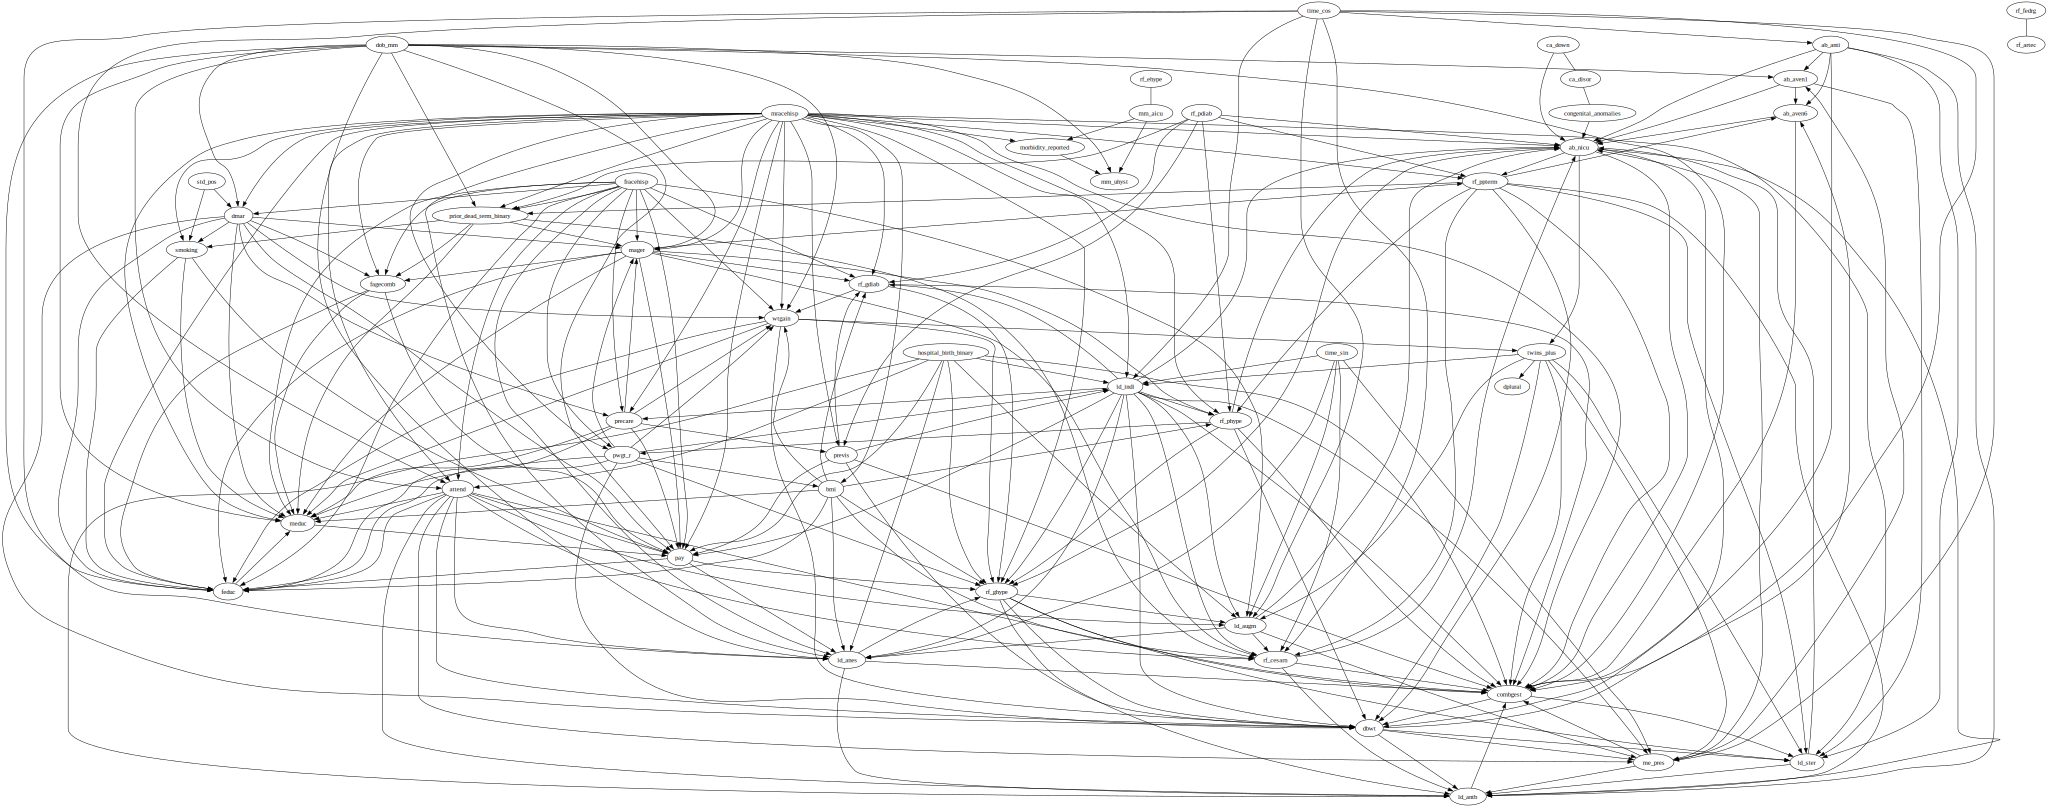

In [12]:
Source(searcher.get_dot())

<h2>PC Stable - Lower P Value</h2>

In [13]:
searcher2 = TetradSearch(X)
searcher2.add_to_tier(0, 'mracehisp')
searcher2.add_to_tier(0, 'fracehisp')
searcher2.add_to_tier(0, 'time_cos')
searcher2.add_to_tier(0, 'time_sin')
searcher2.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher2.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher2.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher2.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher2.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher2.set_forbidden(v, 'time_sin')

In [14]:
searcher2.use_g_square(alpha=0.01)
searcher2.run_pc(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6}, 3={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 4={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 5={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3}, 13={0=0, 1=1, 2=2, 3=3}, 14={0=0, 1=1}, 15={0=0, 1=1}, 16={0=0, 1=1}, 17={0=0, 1=1}, 18={0=0, 1=1}, 19={0=0, 1=1}, 20={0=0, 1=1}, 21={0=0, 1=1}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3, 4=4, 5=5}, 24={0=0, 1=1, 2=2, 3=3}, 25={0=0, 1=1}, 26={0=0, 1=1}, 27={0=0, 1=1}, 28={0=0, 1=1}, 29={0=0, 1=1}, 30={0=0, 1=1}, 31={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8, 9=9, 10=10, 11=11}, 32={0=0, 1=1, 2=2, 3=3}, 33={0=0, 1=1, 2=2, 3=3}, 34={0=0, 1=1, 2=2, 3=3}, 35={0=0, 1=1}, 36={0=0, 1=1, 2=2, 3=3}, 37={0=0, 1=1, 2=2, 3=3}, 38={0=0, 1=1, 2=2, 3=3}, 39={0=0, 1=1, 2=2, 3=3}, 40={0=0, 1=1, 2=2, 3=3}, 41={0=0, 1=1, 2=2, 3=3}, 42={0=0, 1=1, 2=2, 3=

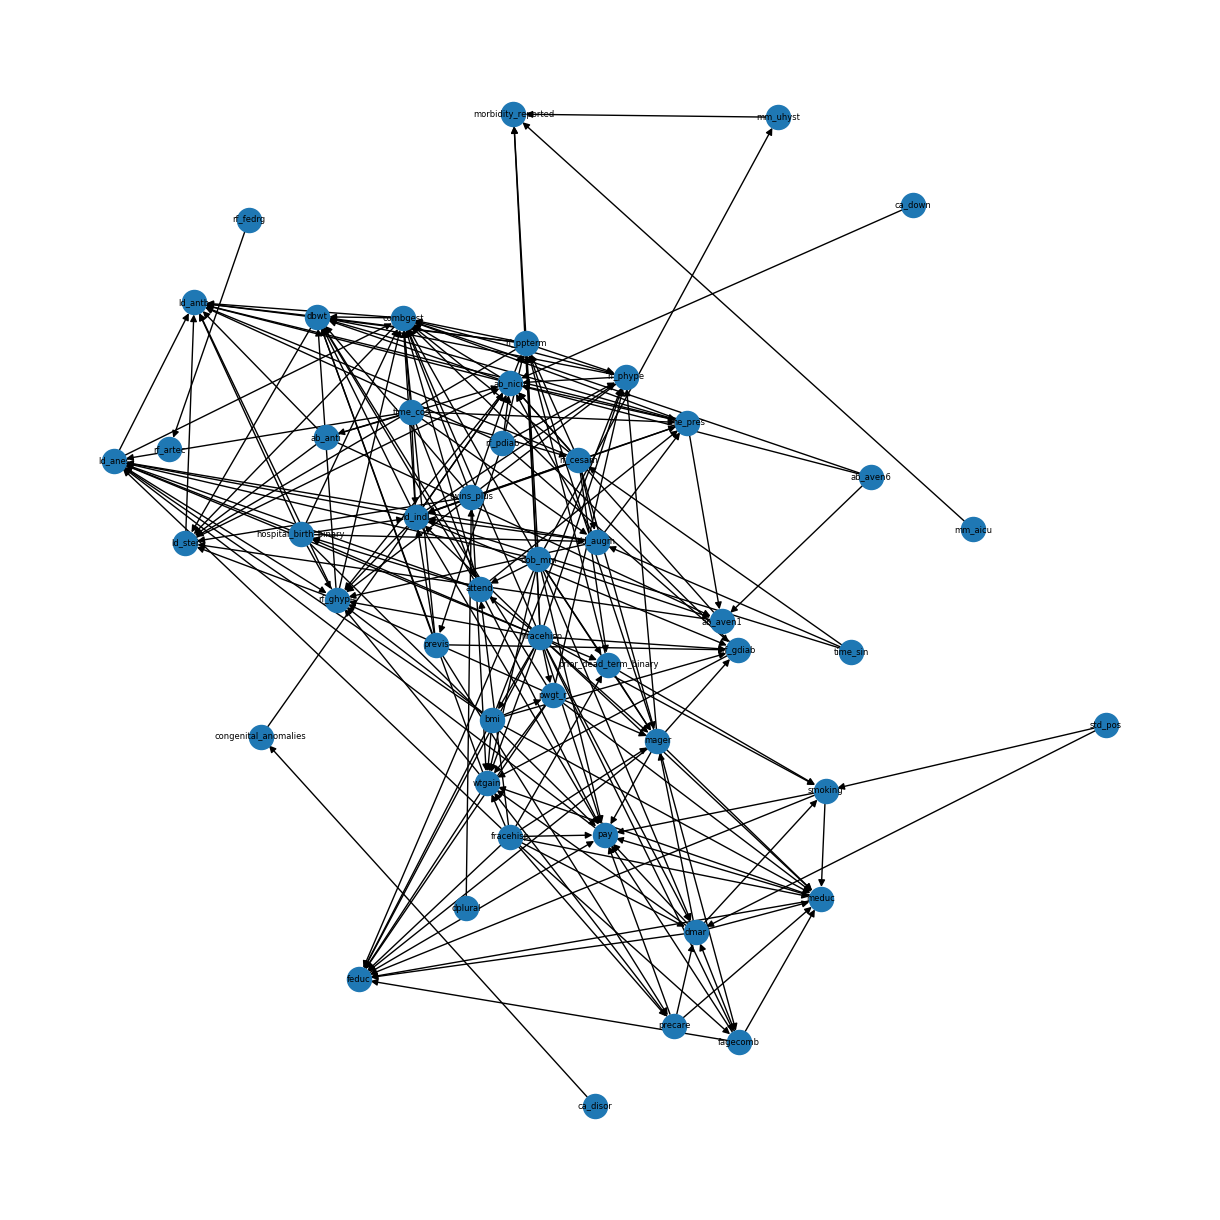

In [15]:
pydot_graph2 = pydot.graph_from_dot_data(searcher2.get_dot())[0]
G2 = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph2))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G2, k=0.6)
nx.draw(G2, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

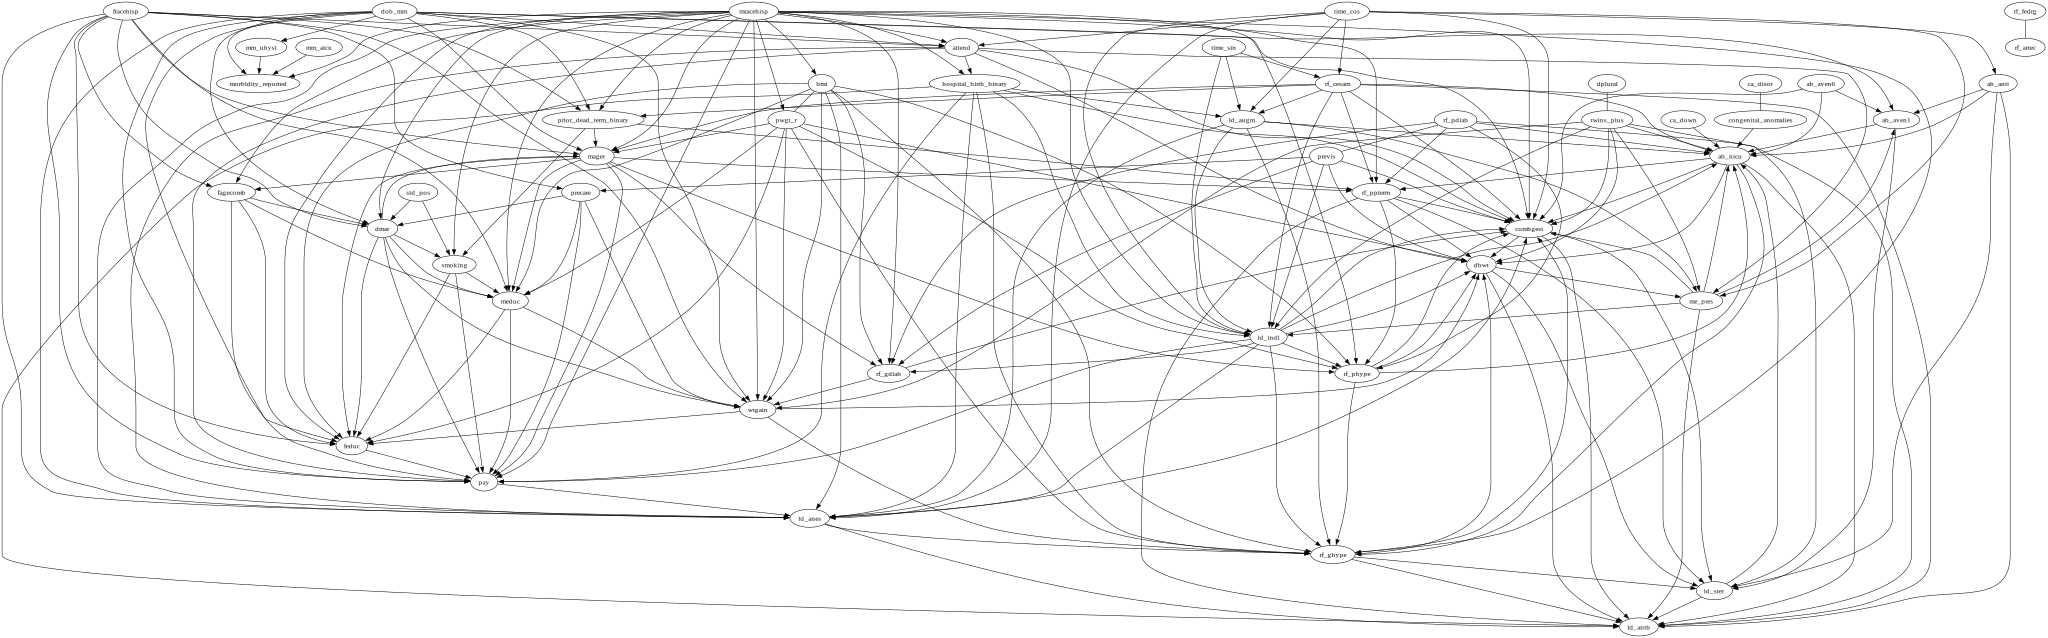

In [16]:
Source(searcher2.get_dot())

<h2>CPC</h2>

In [17]:
searcher3 = TetradSearch(X)
searcher3.add_to_tier(0, 'mracehisp')
searcher3.add_to_tier(0, 'fracehisp')
searcher3.add_to_tier(0, 'time_cos')
searcher3.add_to_tier(0, 'time_sin')
searcher3.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher3.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher3.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher3.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher3.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher3.set_forbidden(v, 'time_sin')

In [18]:
searcher3.use_g_square(alpha=0.05)
searcher3.run_cpc(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6}, 3={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 4={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 5={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3}, 13={0=0, 1=1, 2=2, 3=3}, 14={0=0, 1=1}, 15={0=0, 1=1}, 16={0=0, 1=1}, 17={0=0, 1=1}, 18={0=0, 1=1}, 19={0=0, 1=1}, 20={0=0, 1=1}, 21={0=0, 1=1}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3, 4=4, 5=5}, 24={0=0, 1=1, 2=2, 3=3}, 25={0=0, 1=1}, 26={0=0, 1=1}, 27={0=0, 1=1}, 28={0=0, 1=1}, 29={0=0, 1=1}, 30={0=0, 1=1}, 31={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8, 9=9, 10=10, 11=11}, 32={0=0, 1=1, 2=2, 3=3}, 33={0=0, 1=1, 2=2, 3=3}, 34={0=0, 1=1, 2=2, 3=3}, 35={0=0, 1=1}, 36={0=0, 1=1, 2=2, 3=3}, 37={0=0, 1=1, 2=2, 3=3}, 38={0=0, 1=1, 2=2, 3=3}, 39={0=0, 1=1, 2=2, 3=3}, 40={0=0, 1=1, 2=2, 3=3}, 41={0=0, 1=1, 2=2, 3=3}, 42={0=0, 1=1, 2=2, 3=

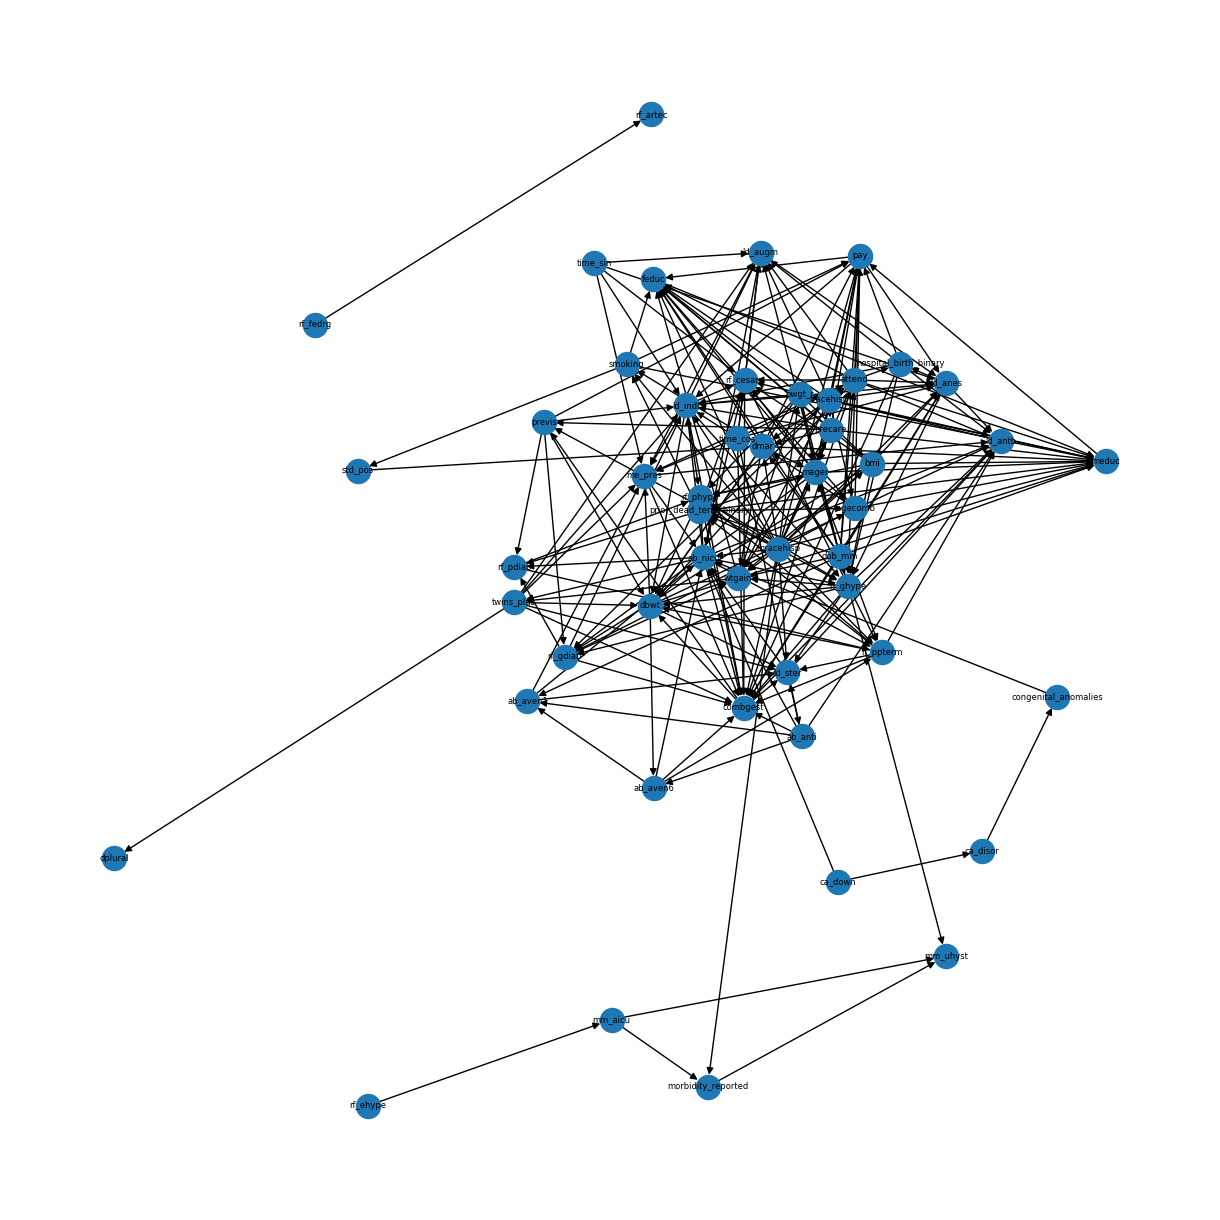

In [19]:
pydot_graph3 = pydot.graph_from_dot_data(searcher3.get_dot())[0]
G3 = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph3))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G3, k=0.6)
nx.draw(G3, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

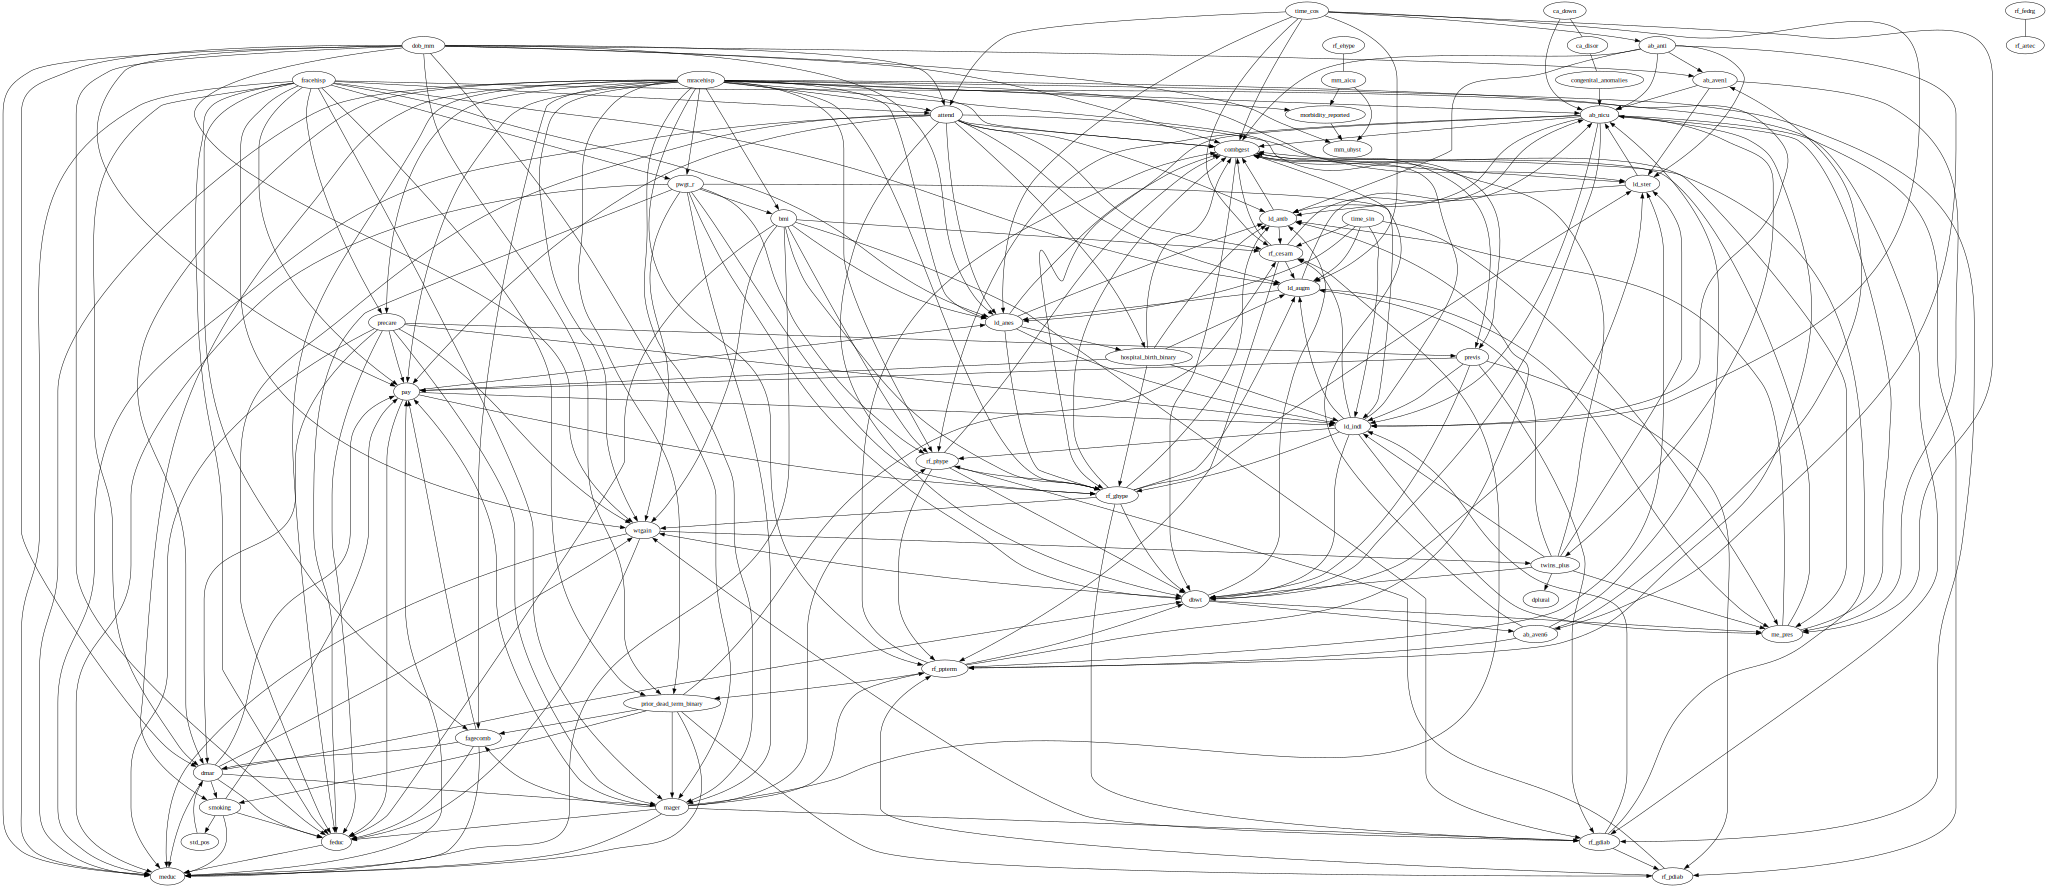

In [20]:
Source(searcher3.get_dot())

<h2>PC-Max</h2>

In [21]:
searcher4 = TetradSearch(X)
searcher4.add_to_tier(0, 'mracehisp')
searcher4.add_to_tier(0, 'fracehisp')
searcher4.add_to_tier(0, 'time_cos')
searcher4.add_to_tier(0, 'time_sin')
searcher4.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher4.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher4.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher4.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher4.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher4.set_forbidden(v, 'time_sin')

In [22]:
searcher4.use_g_square(alpha=0.05)
searcher4.run_pc_max(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6}, 3={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 4={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 5={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3}, 13={0=0, 1=1, 2=2, 3=3}, 14={0=0, 1=1}, 15={0=0, 1=1}, 16={0=0, 1=1}, 17={0=0, 1=1}, 18={0=0, 1=1}, 19={0=0, 1=1}, 20={0=0, 1=1}, 21={0=0, 1=1}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3, 4=4, 5=5}, 24={0=0, 1=1, 2=2, 3=3}, 25={0=0, 1=1}, 26={0=0, 1=1}, 27={0=0, 1=1}, 28={0=0, 1=1}, 29={0=0, 1=1}, 30={0=0, 1=1}, 31={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8, 9=9, 10=10, 11=11}, 32={0=0, 1=1, 2=2, 3=3}, 33={0=0, 1=1, 2=2, 3=3}, 34={0=0, 1=1, 2=2, 3=3}, 35={0=0, 1=1}, 36={0=0, 1=1, 2=2, 3=3}, 37={0=0, 1=1, 2=2, 3=3}, 38={0=0, 1=1, 2=2, 3=3}, 39={0=0, 1=1, 2=2, 3=3}, 40={0=0, 1=1, 2=2, 3=3}, 41={0=0, 1=1, 2=2, 3=3}, 42={0=0, 1=1, 2=2, 3=

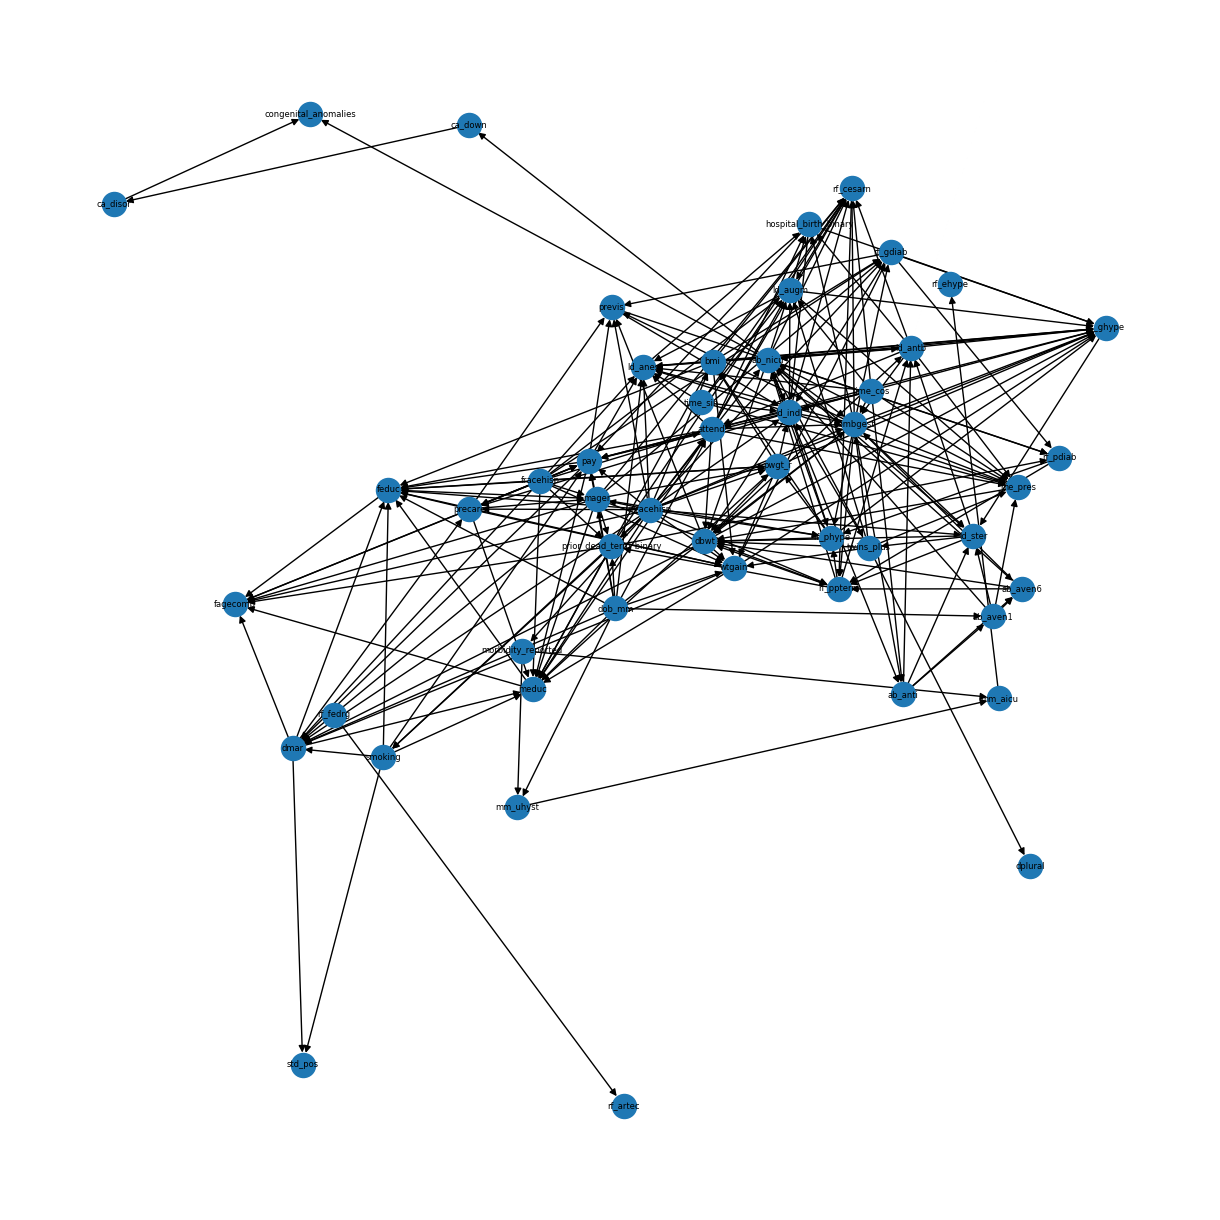

In [23]:
pydot_graph4 = pydot.graph_from_dot_data(searcher4.get_dot())[0]
G4 = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph4))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G4, k=0.6)
nx.draw(G4, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

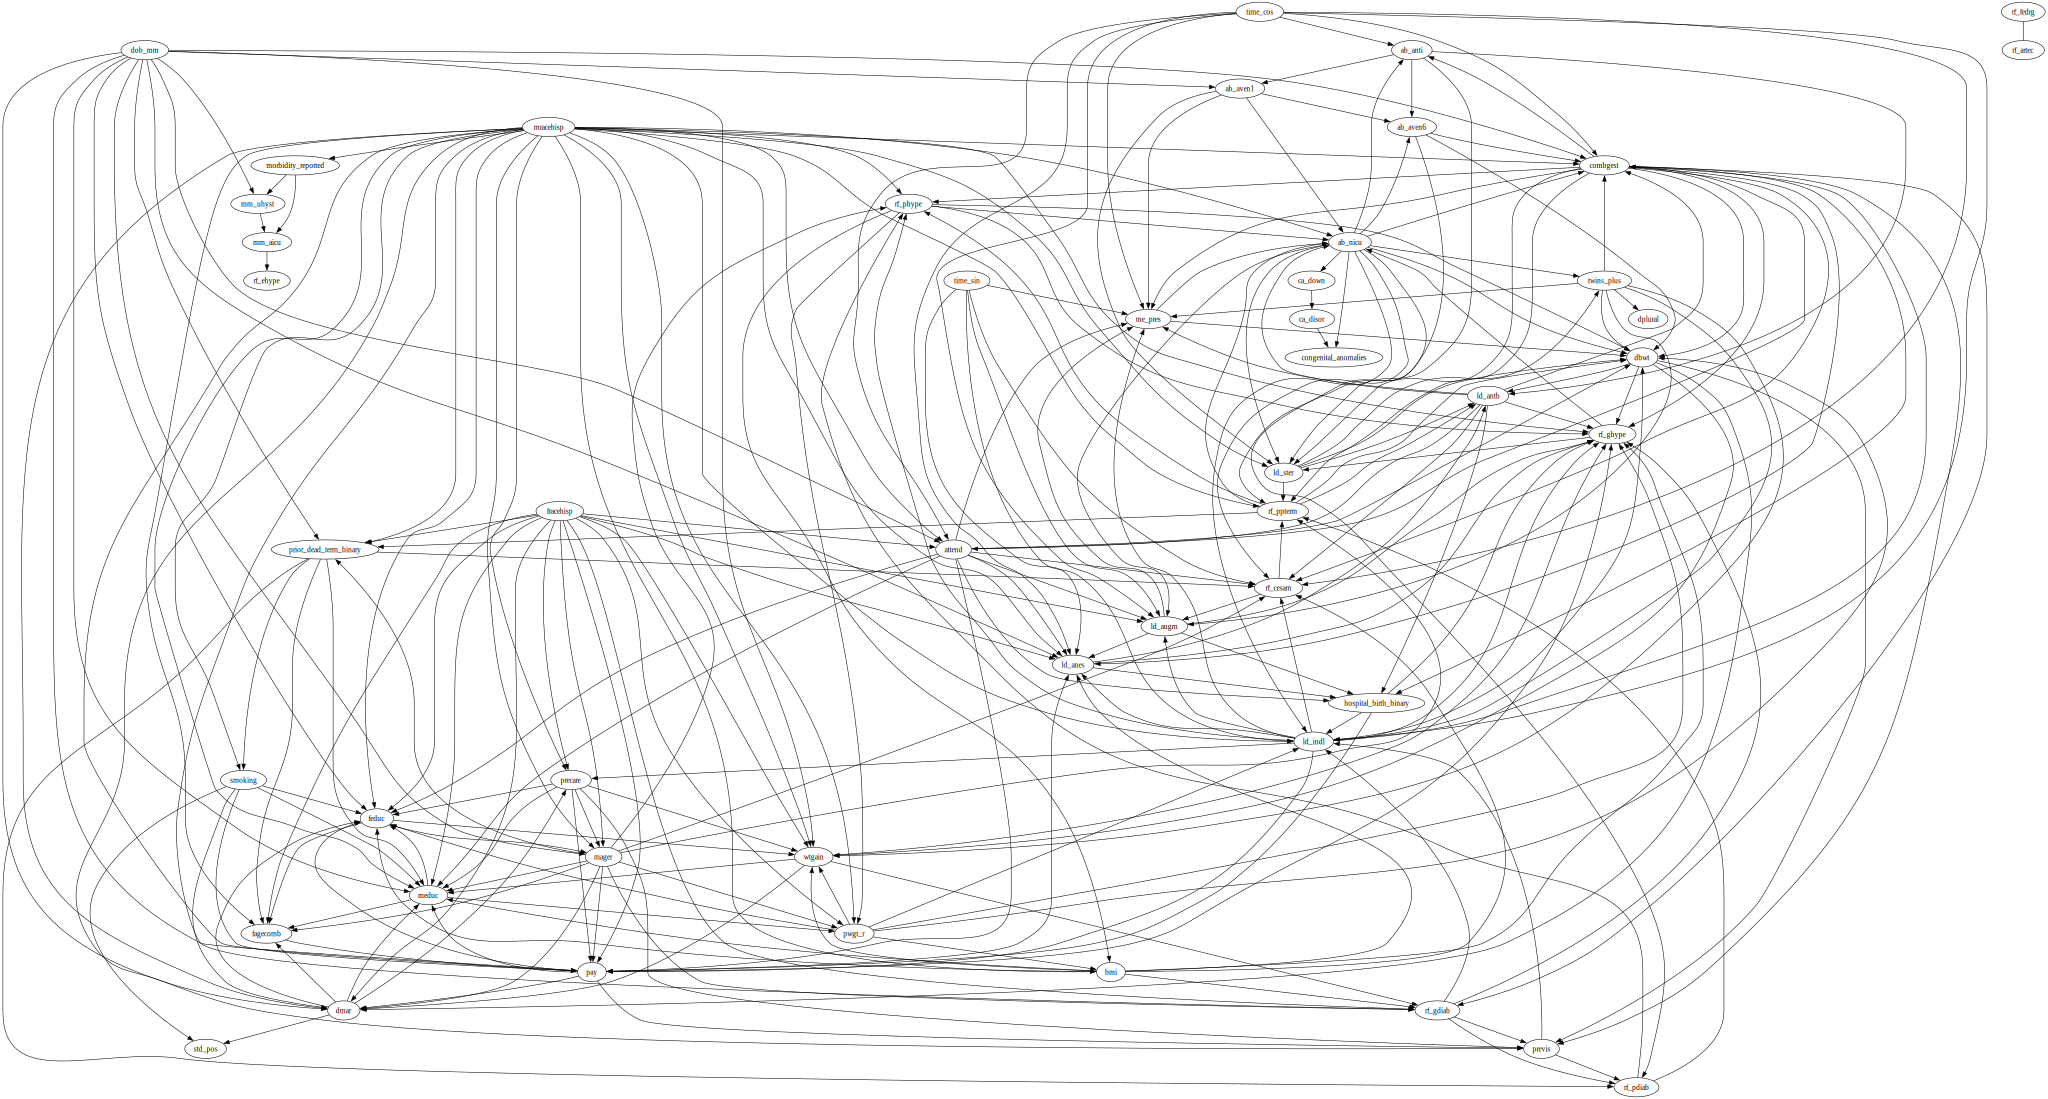

In [24]:
Source(searcher4.get_dot())